We have data from two online concerts.  For each concert people registered ahead of time, then paid by donation.  We would like to predict the future donation revenue based on the number of people signed up for the concert.

It may not be possible to compare the two samples because in the first, people registered by paying a small registration fee and so may have been more likely to follow through and donate at the event.  The second concert was free to register.

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
%matplotlib inline

import seaborn as sns
from scipy import stats
from sklearn.utils import resample


In [2]:
# Get the data
df = pd.read_csv('data/event_donations.csv', index_col=0)

## look at  data

In [3]:
df.describe()

,Amount,Event
count,143.000000,143.000000
mean,33.483916,1.447552
std,42.389571,0.498989
min,1.000000,1.000000
25%,10.000000,1.000000
50%,20.000000,1.000000
75%,40.000000,2.000000
max,303.000000,2.000000


In [42]:
df.sum()

Amount    4788.2
Event      207.0
dtype: float64

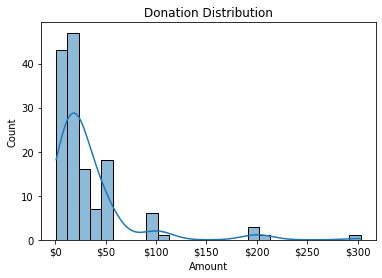

In [50]:
ax = sns.histplot(df.Amount, kde=True )

plt.title('Donation Distribution')

formatter = ticker.FormatStrFormatter('$%1.0f')
ax.xaxis.set_major_formatter(formatter)


We can see from the 5 point stats that the minimum value for the Amount is 1. So the people who did not donate are not included.  We want to add them into this data as guests who donated zero. Our goal is to determine what the nonprofit can expect based on registrations.  If we don't include those our estimate will be too high.

The first event had 109 people register
The second event had 126 people register

To add those in we want to see the difference between the number of people who registered and the number of donations for that event, and pad the list with zeros for the people who didn't donate.

In [51]:
n = 109 - len(df[df['Event'] == 1])
n


30

In [52]:
cheap_skates1 = pd.DataFrame(zip([0 for x in range(n)], [1 for x in range(n)]),
                       columns = ['Amount', 'Event'])
cheap_skates1.head()

,Amount,Event
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1


In [53]:
n = 126 - len(df[df['Event'] == 2])
n


62

In [54]:
cheap_skates2 = pd.DataFrame(zip([0 for x in range(n)], [1 for x in range(n)]),
                       columns = ['Amount', 'Event'])
cheap_skates2

,Amount,Event
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
57,0,1
58,0,1
59,0,1
60,0,1


In [55]:
df_combined = pd.concat([df, cheap_skates1, cheap_skates2])
df_combined

,Amount,Event
0,30.0,1
1,30.0,1
2,30.0,1
3,20.0,1
4,100.0,1
...,...,...
57,0.0,1
58,0.0,1
59,0.0,1
60,0.0,1


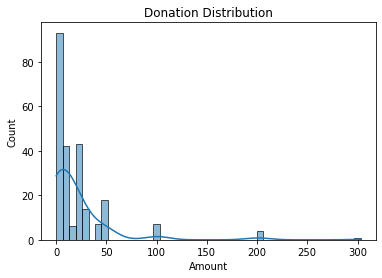

In [57]:
sns.histplot(df_combined['Amount'], kde=True)


plt.title('Donation Distribution')

formatter = ticker.FormatStrFormatter('$%1.0f')
ax.xaxis.set_major_formatter(formatter)


## compare the samples
use a t test to check whether the samples came from the same population.

In [11]:
stats.ttest_ind(df_combined[df_combined['Event'] == 1].Amount,
                df_combined[df_combined['Event'] == 2].Amount)

Ttest_indResult(statistic=-4.144236619752393, pvalue=4.773804526358734e-05)

We fail to reject the null hypothesis that the samples were drawn from the same population.  That means we can assume the samples did come from the same population.

In our case this means that we can assume that these events were similar enough to represent two samples of the same experiment.

## Resample to find the population mean and confidence intervals.

Why?  Because we want to know what to expect for other similar events.  By resampling we get an estimator of the sampling variation in the population.  It won't get us a more accurate mean, but it will tell us that 95 percent of samples should fall within the confidence interval range we calculate for the poputlation.

In [14]:
# Resample event_2_donations
x_bar_star = []

for i in range(10000):
    mean = resample(df_combined.Amount).mean()
    x_bar_star.append(mean)
    
x_bar_star

[17.749787234042554,
 18.00936170212766,
 20.72340425531915,
 19.963404255319148,
 18.481702127659574,
 23.800851063829786,
 17.115744680851062,
 21.80255319148936,
 19.945531914893618,
 17.8,
 21.725106382978723,
 23.06978723404255,
 21.68255319148936,
 15.477446808510637,
 22.37531914893617,
 22.57531914893617,
 20.915744680851063,
 22.14468085106383,
 20.006808510638294,
 18.405106382978722,
 19.56255319148936,
 19.84,
 20.885106382978723,
 26.3131914893617,
 18.09531914893617,
 21.6,
 21.259574468085106,
 22.026382978723404,
 20.33191489361702,
 20.80595744680851,
 20.644255319148936,
 20.626382978723402,
 19.50723404255319,
 21.406808510638296,
 16.42127659574468,
 18.36255319148936,
 22.646808510638298,
 19.781276595744682,
 21.740425531914894,
 19.56255319148936,
 25.146382978723402,
 17.044255319148935,
 22.057021276595744,
 25.236595744680848,
 24.58042553191489,
 16.57276595744681,
 21.382978723404257,
 23.63063829787234,
 22.068936170212766,
 19.46808510638298,
 20.605106382

In [15]:
x_bar = df_combined['Amount'].mean()
error = np.array(x_bar_star) - x_bar

<AxesSubplot:ylabel='Count'>

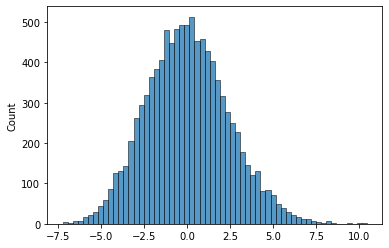

In [19]:
sns.histplot(error)

## Calculate confidence interval.


In [26]:
errors = np.quantile(error, [.025,.975])
errors

array([-4.36170213,  4.96697872])

In [28]:
df_combined['Amount'].mean() + errors[0], df_combined['Amount'].mean() + errors[1]

(16.013617021276595, 25.34229787234042)

# Try for each event separatly

In [30]:
df1 = df_combined[df_combined['Event'] == 1]
df2 = df_combined[df_combined['Event'] == 2]

In [40]:
# Resample event_1_donations
x_bar_star = []

for i in range(1000):
    mean = resample(df1.Amount).mean()
    x_bar_star.append(mean)
    
x_bar = df1['Amount'].mean()
error = np.array(x_bar_star) - x_bar

errors = np.quantile(error, [.025,.975])
errors

x_bar, x_bar + errors[0], x_bar + errors[1]

(14.47953216374269, 10.449707602339181, 19.462134502923973)

In [ ]:
That average donation seems low


In [41]:
# Resample event_2_donations
x_bar_star = []

for i in range(1000):
    mean = resample(df2.Amount).mean()
    x_bar_star.append(mean)
    
x_bar = df2['Amount'].mean()
error = np.array(x_bar_star) - x_bar

errors = np.quantile(error, [.025,.975])

x_bar, x_bar + errors[0], x_bar + errors[1]

(36.128125, 25.921093749999997, 48.7203125)

References:
https://towardsdatascience.com/a-complete-guide-to-confidence-interval-and-examples-in-python-ff417c5cb593

https://moderndive.com/8-confidence-intervals.html

